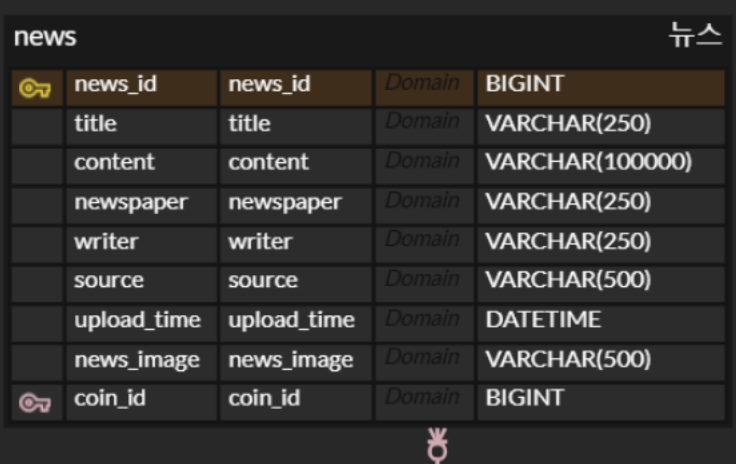

In [8]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
from datetime import datetime
from IPython.display import display, HTML

# CryptoPanic API 설정
API_KEY = "836cfd356356c24c55981ab263ba84a9f3c4941c"
API_URL = f"https://cryptopanic.com/api/v1/posts/?auth_token={API_KEY}"

# Selenium 실행 옵션
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("user-agent=Mozilla/5.0")

# ChromeDriver 자동 설치 및 실행
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# 날짜 파싱 함수 (GMT+0900 제거)
def parse_datetime(time_element):
    try:
        raw_datetime = time_element["datetime"] if time_element else "N/A"
        cleaned_datetime = re.sub(r" GMT[+-]\d{4} \(.*?\)", "", raw_datetime)
        return datetime.strptime(cleaned_datetime, "%a %b %d %Y %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print(f"⚠️ 시간 파싱 오류: {str(e)}")
        return "N/A"

# **원본 뉴스 링크 가져오기 함수 (개선된 코드)**
def get_original_news_link(soup):
    try:
        detail_pane = soup.find("div", id="detail_pane")
        if detail_pane:
            links = detail_pane.find_all("a", href=True)
            for link in links:
                if "http" in link["href"]:  
                    return link["href"]
        return "N/A"
    except Exception as e:
        print(f"⚠️ 원본 뉴스 링크 가져오기 오류: {str(e)}")
        return "N/A"

# CoinGecko에서 코인 이미지 가져오기
def get_coin_image(coin_ticker):
    try:
        response = requests.get("https://api.coingecko.com/api/v3/coins/markets",
                                params={"vs_currency": "usd", "order": "market_cap_desc", "per_page": 250, "page": 1, "sparkline": False})
        coins = response.json()
        for coin in coins:
            if coin_ticker.lower() in [coin["symbol"].lower(), coin["id"].lower()]:
                return coin["image"]
    except Exception as e:
        print(f"⚠️ CoinGecko API 오류: {str(e)}")
    return "N/A"

# 가져올 뉴스 개수
NEWS_COUNT = 5

# 결과 저장을 위한 리스트
news_data = []

### **1️⃣ CryptoPanic API에서 뉴스 목록 가져오기**
try:
    response = requests.get(API_URL, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    for post in data["results"][:NEWS_COUNT]:
        title_en = post["title"]
        title_ko = GoogleTranslator(source="en", target="ko").translate(title_en)
        crypto_panic_url = post["url"]
        coin_ticker = post.get("currencies", [{}])[0].get("code", "N/A")
        coin_image = get_coin_image(coin_ticker)

        # Selenium으로 뉴스 페이지 접속
        driver.get(crypto_panic_url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # 원본 뉴스 링크 가져오기 (개선된 코드 적용)
        original_news_link = get_original_news_link(soup)

        # 뉴스 날짜 가져오기
        time_element = soup.find("time")
        news_datetime = parse_datetime(time_element)

        # 뉴스 요약 가져오기
        description_div = soup.find("div", class_="description")
        if description_div:
            article_text = "\n".join([p.get_text() for p in description_div.find_all("p")])
            translated_text = GoogleTranslator(source="en", target="ko").translate(article_text)
        else:
            translated_text = "❌ 뉴스 요약 없음"

        print(f"\n🔹 {title_ko}")
        print(f"📅 뉴스 날짜: {news_datetime}")
        print(f"🔗 원본 뉴스 링크: {original_news_link}")
        print(f"💰 코인 티커: {coin_ticker}")
        print(f"🖼️ 코인 이미지 URL: {coin_image}")

        # 데이터 저장
        news_data.append([title_ko, translated_text, original_news_link, news_datetime, coin_ticker, coin_image])

        print("-" * 80)

except Exception as e:
    print(f"❌ CryptoPanic API 요청 오류: {str(e)}")

finally:
    driver.quit()

# **결과를 데이터프레임으로 변환**
df = pd.DataFrame(news_data, columns=["title", "content", "source", "upload_time", "coin_id", "coin_image"])

# **컬럼 순서 조정**
df = df[["title", "content", "source", "upload_time", "coin_id", "coin_image"]]

# **HTML에서 이미지 & 링크 표시**
df["coin_image"] = df["coin_image"].apply(lambda x: f'<img src="{x}" width="50">' if x != "N/A" else "N/A")
df["source"] = df["source"].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>' if x != "N/A" else "N/A")

# **출력**
display(HTML(df.to_html(escape=False)))



🔹 이더 리움의 다음 움직임은 이러한 중요한 가격 수준에 의해 결정될 수 있습니다.
📅 뉴스 날짜: 2025-02-08 19:00:36
🔗 원본 뉴스 링크: https://cryptodnes.bg/en/ethereums-next-move-could-be-determined-by-these-critical-price-levels/
💰 코인 티커: ETH
🖼️ 코인 이미지 URL: https://coin-images.coingecko.com/coins/images/279/large/ethereum.png?1696501628
--------------------------------------------------------------------------------

🔹 2025 년에서 2030 년까지의 공식 Melania Memecoin 가격 예측
📅 뉴스 날짜: 2025-02-08 19:00:00
🔗 원본 뉴스 링크: https://crypto-economy.com/melania-price-prediction/
💰 코인 티커: MELANIA
🖼️ 코인 이미지 URL: N/A
--------------------------------------------------------------------------------

🔹 Bitcoin은 동전으로 백만 달러에 달할 것입니다. 일부를 소유하고 있기를 바랍니다.
📅 뉴스 날짜: 2025-02-08 18:47:04
🔗 원본 뉴스 링크: https://www.youtube.com/watch?v=2fTdPEr25F0
💰 코인 티커: BTC
🖼️ 코인 이미지 URL: https://coin-images.coingecko.com/coins/images/1/large/bitcoin.png?1696501400
--------------------------------------------------------------------------------

🔹 플로리다 상원 의원은 인플레이션에 대한 헤지에 비트 코인에 대한 주 

,title,content,source,upload_time,coin_id,coin_image
0,이더 리움의 다음 움직임은 이러한 중요한 가격 수준에 의해 결정될 수 있습니다.,cryptocurrency 분석 회사 인 Makrovision은 다음 방향을 결정할 수있는 이더 리움 (ETH)의 중요한 가격 수준을 강조했습니다.\n이더 리움의 다음 움직임은 이러한 중요한 가격 수준에 의해 결정될 수 있습니다.,https://cryptodnes.bg/en/ethereums-next-move-could-be-determined-by-these-critical-price-levels/,2025-02-08 19:00:36,ETH,
1,2025 년에서 2030 년까지의 공식 Melania Memecoin 가격 예측,"TL; Melania Trump의 공식 Melania Meme Coin ($ Melania)은 2025 년에 시작하여 디지털 금융과 문화적 영향을 결합하여 지역 사회의 혼합 반응을 이끌어 냈습니다. 2025 년에서 2030 년까지 멜라니 아의 가격 예측은 2025 년에 최대 8.25 달러, 2030 년까지 계속 될 것으로 예상되는 상당한 성장 잠재력을 보여줍니다. 분석가들은 상당한 가격을 예측합니다.",https://crypto-economy.com/melania-price-prediction/,2025-02-08 19:00:00,MELANIA,N/A
2,Bitcoin은 동전으로 백만 달러에 달할 것입니다. 일부를 소유하고 있기를 바랍니다.,,https://www.youtube.com/watch?v=2fTdPEr25F0,2025-02-08 18:47:04,BTC,
3,플로리다 상원 의원은 인플레이션에 대한 헤지에 비트 코인에 대한 주 투자를 제안합니다.,플로리다 공화당 상원 의원 Joe Gruters는 주정부가 자금의 일부를 인플레이션에 대한 헤지로 비트 코인 및 기타 디지털 자산에 자금의 일부를 할당한다는 법안을 도입했습니다.\n플로리다 후 상원 의원은 비트 코인에 대한 주 투자를 제안하여 인플레이션에 대한 헤지가 Cryptonews에서 처음으로 나타났습니다.,https://cryptonews.com/news/florida-senator-proposes-state-investment-in-bitcoin-to-hedge-against-inflation/,2025-02-08 18:47:04,BTC,
4,Ondo Finance가 새로운 L1을 밝히는 것처럼 Cosmos Ecosystem,"Cosmos 생태계는 최근 Ondo Finance의 새로운 계층 1 블록 체인 1 블록 체인을 제도적 등급 RWAS, Ondo Chain에 대한 발표와 함께 실제 자산 (RWA)의 허브가되고 있습니다. Ondo Chain은 뉴욕의 Ondo Summit에서 공개되었으며, Donald Trump Jr.“미국의 RWAS의 미래 […]\n포스트 코스모스 생태계는 rwas로 집에 돌아 왔습니다 ...",https://cryptoslate.com/cosmos-ecosystem-becoming-home-for-rwas-as-ondo-finance-reveals-new-l1/,2025-02-08 18:47:04,ONDO,
